In [ ]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from geopy.distance import geodesic

In [ ]:
river_stations = pd.read_csv('output/rivers_stations_2002_2024.csv')

river_stations['geometry'] = gpd.points_from_xy(river_stations['lon'], river_stations['lat'])
river_stations = gpd.GeoDataFrame(river_stations, crs="EPSG:4326")
river_stations = river_stations.to_crs("EPSG:3035")
river_stations = river_stations[~river_stations['river'].str.contains('jezer', case=False)]


prec_stations = pd.read_csv('output/precipitation_stations_2002_2024.csv')
prec_stations['geometry'] = gpd.points_from_xy(prec_stations['lon'], prec_stations['lat'])
prec_stations = gpd.GeoDataFrame(prec_stations, crs="EPSG:4326")
prec_stations = prec_stations.to_crs("EPSG:3035")

weather_stations = pd.read_csv('output/weather_automatic_stations_2002-01-01_2024-07-23.csv')
weather_stations['geometry'] = gpd.points_from_xy(weather_stations['lon'], weather_stations['lat'])
weather_stations = gpd.GeoDataFrame(weather_stations, crs="EPSG:4326")
weather_stations = weather_stations.to_crs("EPSG:3035")

river_data = pd.read_csv('output/rivers_data_2002_2024.csv')
prec_data = pd.read_csv('output/precipitation_data_2002_2024.csv')


In [ ]:
prec_stations

In [ ]:
import ast

# Define a converter function to convert list-like strings to actual lists
def convert_to_list(value):
    return ast.literal_eval(value)

# Read the CSV file with converters for the list columns
close_river_prec = pd.read_csv('output/rivers_to_close_weather_stations.csv', converters={
    'precip_ids': convert_to_list,
    'precip_distances': convert_to_list
})


In [ ]:
import networkx as nx

G = nx.Graph()


In [ ]:
# filter out the prec stations where start_year = 2002, end_year = 2024
prec_stations = prec_stations[(prec_stations['start_year'] == 2002) & (prec_stations['end_year'] == 2024)]

In [ ]:
for r in river_stations.iterrows():
    G.add_node(f'r_{r[1]["id"]}', station_type='river', station_name=r[1]['name'], lat=r[1]['lat'], lon=r[1]['lon'])

In [ ]:
for p in prec_stations.iterrows():
    G.add_node(f"p_{p[1]['id']}", station_type='prec', station_name=p[1]['name'], lat=p[1]['lat'], lon=p[1]['lon'], alt=p[1]['alt'])

In [ ]:
close_river_prec.head()

In [ ]:
for _, c in close_river_prec.iterrows():
    r_id = c['id']
    
    if f"r_{r_id}" not in G.nodes:
        continue
    
    for i, p in enumerate(c['precip_ids']):
        if f"p_{p}" not in G.nodes:
            print(p)
            continue
        G.add_edge(f'r_{c["id"]}', f'p_{p}', dist=c['precip_distances'][i])

In [ ]:
# plot the graph, with the river stations in red and the precipitation stations in blue
# use pyvis to plot the graph

from pyvis.network import Network
import networkx as nx

nt = Network(height='100vh', width='100%', directed=False)
nt.from_nx(G)

# Set node colors based on type
for node in nt.nodes:
    node['color'] = 'blue' if node['station_type'] == 'river' else 'red'
    # add station_name to tooltip
    node['title'] = node['station_name']
    # add lat, lon to tooltip
    node['title'] += f"\nlat: {node['lat']}, lon: {node['lon']}"
    # add alt to tooltip
    if 'alt' in node:
        node['title'] += f"<br>alt: {node['alt']}"
        
    # add 
    
# add edge weight
for edge in nt.edges:
    edge['title'] = edge['dist']
    edge['width'] = min(edge['dist'], 10)  # You can scale this if needed
    # set edge color
    edge['color'] = 'gray'

nt.show("nx.html", notebook=False)


In [ ]:
danube_l = gpd.read_file('./euhydro/euhydro_danube_v013.gpkg', layer='River_Net_l')
po_l = gpd.read_file('./euhydro/euhydro_po_v013.gpkg', layer='River_Net_l')

In [ ]:
slovenia = gpd.read_file('SR.geojson')

In [ ]:
# danube_l = danube_l.to_crs("EPSG:3035")
# po_l = po_l.to_crs("EPSG:3035")
slovenia = slovenia.to_crs("EPSG:3035")

In [ ]:
slo_bb = slovenia.total_bounds
minx, miny, maxx, maxy = slo_bb
minx, miny = minx - 1e5, miny - 1e5
maxx, maxy = maxx + 1e5, maxy + 1e5

danube_l = danube_l.cx[minx:maxx, miny:maxy]
po_l = po_l.cx[minx:maxx, miny:maxy]

In [ ]:
# plot over slovenia
fig, ax = plt.subplots(figsize=(15, 15))

slovenia.plot(ax=ax, alpha=0.3, color='red')
danube_l.plot(ax=ax, alpha=0.5)
po_l.plot(ax=ax, alpha=0.5)

plt.show()

In [ ]:
def plot_over_slovenia(gdfs):
    fig, ax = plt.subplots(figsize=(15, 15))

    slovenia.plot(ax=ax, alpha=1.0, color='red')
    for gdf in gdfs:
        gdf.plot(ax=ax, alpha=0.5)

    plt.show()

In [ ]:
# plot over slovenia
fig, ax = plt.subplots(figsize=(15, 15))

slovenia.plot(ax=ax, alpha=0.3, color='red')
danube_l.plot(ax=ax, alpha=0.5)
po_l.plot(ax=ax, alpha=0.5)

plt.show()

In [ ]:
# for each river_station point geomtry find the cloest river geometry section mulitline z string

def find_closest_river_section(centroid, all_points, max_distance=10000):

    # Use spatial index to filter candidates
    possible_matches_index = list(all_points.sindex.query(centroid, predicate="dwithin", distance=max_distance))
    possible_matches = all_points.iloc[possible_matches_index]
    distances = possible_matches.distance(centroid)

    closest_points = distances.nsmallest(1)

    return closest_points.index.tolist(), closest_points.tolist()


rivers_m = pd.concat([danube_l, po_l])

river_stations_m = river_stations.copy()

rivers_m['centroid'] = rivers_m['geometry'].centroid

rivers_m.sindex
river_stations_m.sindex

closest_results = river_stations_m['geometry'].apply(lambda centroid: find_closest_river_section(centroid, rivers_m))

river_stations_m['closest_ids'], river_stations_m['distances'] = zip(*closest_results)

# handle also min() arg is an empty sequence
river_stations_m['closest_ids'] = river_stations_m['closest_ids'].apply(lambda x: x[0] if x else None)
river_stations_m['distances'] = river_stations_m['distances'].apply(lambda x: x[0] if x else None)

In [ ]:
river_stations_m

In [ ]:
river_stations_m[river_stations_m['distances'] > 60]

In [ ]:
# plot slovenia and single geometry

fig, ax = plt.subplots(figsize=(15, 15))

slovenia.plot(ax=ax, alpha=0.1, color='red')

river_stations_m.loc[12:12].plot(ax=ax, color='yellow', alpha=1)
rivers_m.loc[66698:66698].plot(ax=ax, alpha=1)

In [ ]:
closest_river_section_ids = river_stations_m['closest_ids'].tolist()




In [144]:
# for each river_section in rivers_m find the closest weather station

def find_closest_weather_stations(centroid, all_points, n_closest=5, max_distance=200000):
    
        # Use spatial index to filter candidates
        possible_matches_index = list(all_points.sindex.query(centroid, predicate="dwithin", distance=max_distance))
        possible_matches = all_points.iloc[possible_matches_index]
        distances = possible_matches.distance(centroid)
    
        closest_points = distances.nsmallest(n_closest)
    
        return closest_points.index.tolist(), closest_points.tolist()


weather_stations_x = weather_stations.copy()
weather_stations_x['centroid'] = weather_stations_x['geometry'].centroid

weather_stations_x.sindex

n_closest = 5
closest_results = rivers_m['geometry'].apply(lambda centroid: find_closest_weather_stations(centroid, weather_stations_x, n_closest))

rivers_m['closest_weather_ids'], rivers_m['closest_weather_dist'] = zip(*closest_results)

rivers_m['closest_weather_ids'] = rivers_m['closest_weather_ids'].apply(lambda x: x if x else None)

rivers_m = rivers_m[rivers_m['closest_weather_dist'].apply(lambda x: x[0] if x else 0) <= 30000]

# remove te river sections that have distances equal to nan
rivers_m = rivers_m[~rivers_m['closest_weather_dist'].isna()]
rivers_m = rivers_m[~rivers_m['closest_weather_ids'].isnull()]


<Axes: >

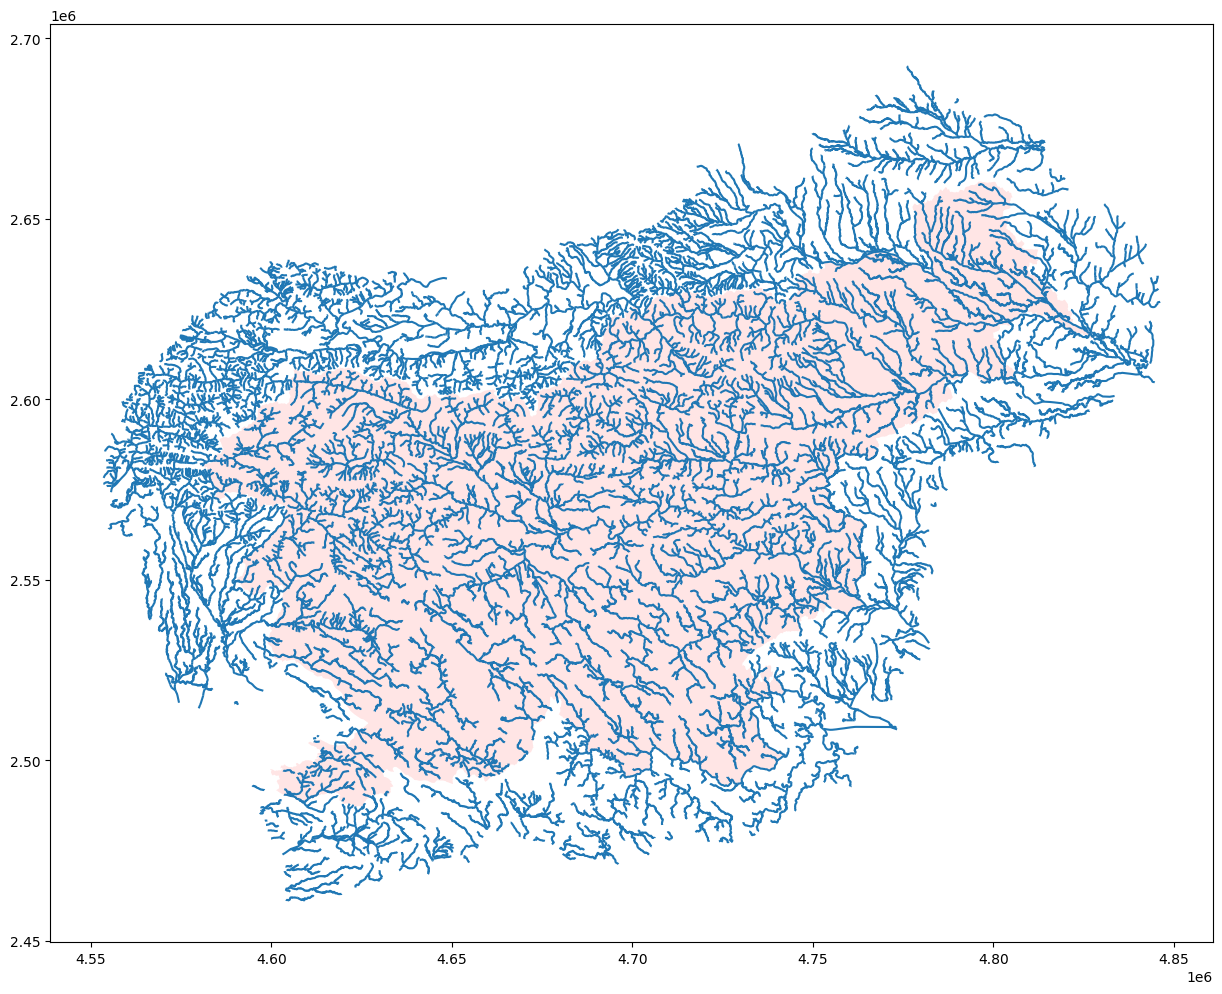

In [145]:
fig, ax = plt.subplots(figsize=(15, 15))

slovenia.plot(ax=ax, alpha=0.1, color='red')    
rivers_m.plot(ax=ax, alpha=1)

In [146]:
# for each river section plot the closest precipitation station geometry point

prec_stations_m = prec_stations.copy()
prec_stations_m['centroid'] = prec_stations_m['geometry'].centroid

prec_stations_m.sindex

# use same function as was implemented before

n_closest = 5
closest_results = rivers_m['geometry'].apply(lambda centroid: find_closest_weather_stations(centroid, prec_stations_m, n_closest))

rivers_m['closest_prec_ids'], rivers_m['closest_prec_dist'] = zip(*closest_results)

rivers_m['closest_prec_ids'] = rivers_m['closest_prec_ids'].apply(lambda x: x if x else None)


In [147]:
rivers_m

,DFDD,RN_I_ID,REX,HYP,LOC,FUN,NVS,LENGTH,TR,LONGPATH,...,CatchID,PFAFSTETTER,geometry,centroid,closest_weather_ids,distances,closest_prec_ids,closest_prec_distances,closest_weather_dist,closest_prec_dist
17840,BH140,None,HR,1.0,44.0,6.0,5.0,3982.780029,Z000205378,3982.777100,...,152,None,MULTILINESTRING Z ((4607318.051 2461881.949 48...,POINT (4605604.933 2461700.739),"[12, 63, 111, 121, 31]","[29685.78925294782, 38150.22614687352, 38540.7...","[54, 160, 56, 13, 16]","[31753.60517842973, 37209.43448350522, 38409.2...","[29685.78925294782, 38150.22614687352, 38540.7...","[31753.60517842973, 37209.43448350522, 38409.2..."
17847,BH140,None,HR,1.0,44.0,6.0,5.0,281.529999,Z000205378,4264.309082,...,152,None,MULTILINESTRING Z ((4607527.559 2462059.7 51.4...,POINT (4607431.195 2461959.004),"[12, 111, 63, 121, 31]","[29785.888708348033, 38348.99596514935, 38536....","[54, 160, 56, 13, 16]","[31894.67824420707, 36945.871991979104, 38140....","[29785.888708348033, 38348.99596514935, 38536....","[31894.67824420707, 36945.871991979104, 38140...."
17867,BH140,None,HR,NaN,NaN,NaN,NaN,6472.660156,NA,10455.434570,...,152,None,"MULTILINESTRING Z ((4611737.5 2462212.5 0, 461...",POINT (4609545.308 2461739.549),"[12, 121, 111, 63, 31]","[29938.78280142003, 37137.1617248192, 37675.87...","[54, 160, 56, 13, 33]","[32043.58732160808, 34553.08409990205, 35469.4...","[29938.78280142003, 37137.1617248192, 37675.87...","[32043.58732160808, 34553.08409990205, 35469.4..."
17945,BH140,None,HR,1.0,44.0,6.0,5.0,1562.699951,NA,1562.704834,...,149,None,MULTILINESTRING Z ((4605246.183 2463549.838 28...,POINT (4604586.517 2463880.846),"[12, 63, 111, 121, 31]","[27439.108659575133, 35702.1378847486, 36860.3...","[54, 160, 56, 13, 16]","[29471.619683931633, 36995.357854076574, 38430...","[27439.108659575133, 35702.1378847486, 36860.3...","[29471.619683931633, 36995.357854076574, 38430..."
17955,BH140,None,HR,NaN,NaN,NaN,NaN,10446.330078,NA,20509.871094,...,148,None,"MULTILINESTRING Z ((4619512.5 2462987.5 0, 461...",POINT (4615551.046 2463469.305),"[12, 121, 111, 31, 63]","[28298.951605091228, 34522.47529603619, 35642....","[54, 160, 56, 13, 33]","[30465.477271027583, 31096.1836670437, 31321.2...","[28298.951605091228, 34522.47529603619, 35642....","[30465.477271027583, 31096.1836670437, 31321.2..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57134,BH140,None,SI,1.0,44.0,6.0,5.0,1216.520020,NA,25691.710938,...,28,None,"MULTILINESTRING Z ((4643937.5 2515612.5 0, 464...",POINT (4644416.272 2515032.143),"[113, 38, 76, 16, 119]","[8203.138081677807, 11141.09283294168, 11579.3...","[33, 86, 57, 59, 34]","[11347.613017824022, 19523.82646756753, 21386....","[8203.138081677807, 11141.09283294168, 11579.3...","[11347.613017824022, 19523.82646756753, 21386...."
57135,BH140,None,SI,1.0,44.0,6.0,5.0,710.239990,NA,53875.554688,...,28,None,"MULTILINESTRING Z ((4644787.5 2531287.5 0, 464...",POINT (4644258.701 2530234.906),"[119, 38, 83, 101, 136]","[4527.763459594581, 4719.809861163654, 7791.45...","[57, 86, 33, 144, 58]","[6906.233539896489, 8000.9620087566545, 8081.0...","[4527.763459594581, 4719.809861163654, 7791.45...","[6906.233539896489, 8000.9620087566545, 8081.0..."
57136,BH140,None,SI,1.0,44.0,6.0,5.0,1028.930054,NA,43104.562500,...,28,None,"MULTILINESTRING Z ((4648512.5 2525262.5 0, 464...",POINT (4648022.987 2524697.406),"[38, 119, 83, 76, 27]","[1354.8993410414166, 1833.295561933778, 11149....","[86, 33, 59, 57, 144]","[8901.05109644118, 10437.15715809448, 12972.36...","[1354.8993410414166, 1833.295561933778, 11149....","[8901.05109644118, 10437.15715809448, 12972.36..."
57137,BH140,None,SI,1.0,44.0,6.0,5.0,1060.589966,NA,41722.625000,...,28,None,"MULTILINESTRING Z ((4657537.5 2503212.5 0, 465...",POINT (4656739.504 2502300.5),"[18, 72, 76, 113, 27]","[4499.797833145919, 7622.888355618298, 12417.5...","[34, 56, 59, 187, 33]","[19636.82864852497, 26778.668288313693, 27219....","[4499.797833145919, 7622.888355618298, 12417

<Axes: >

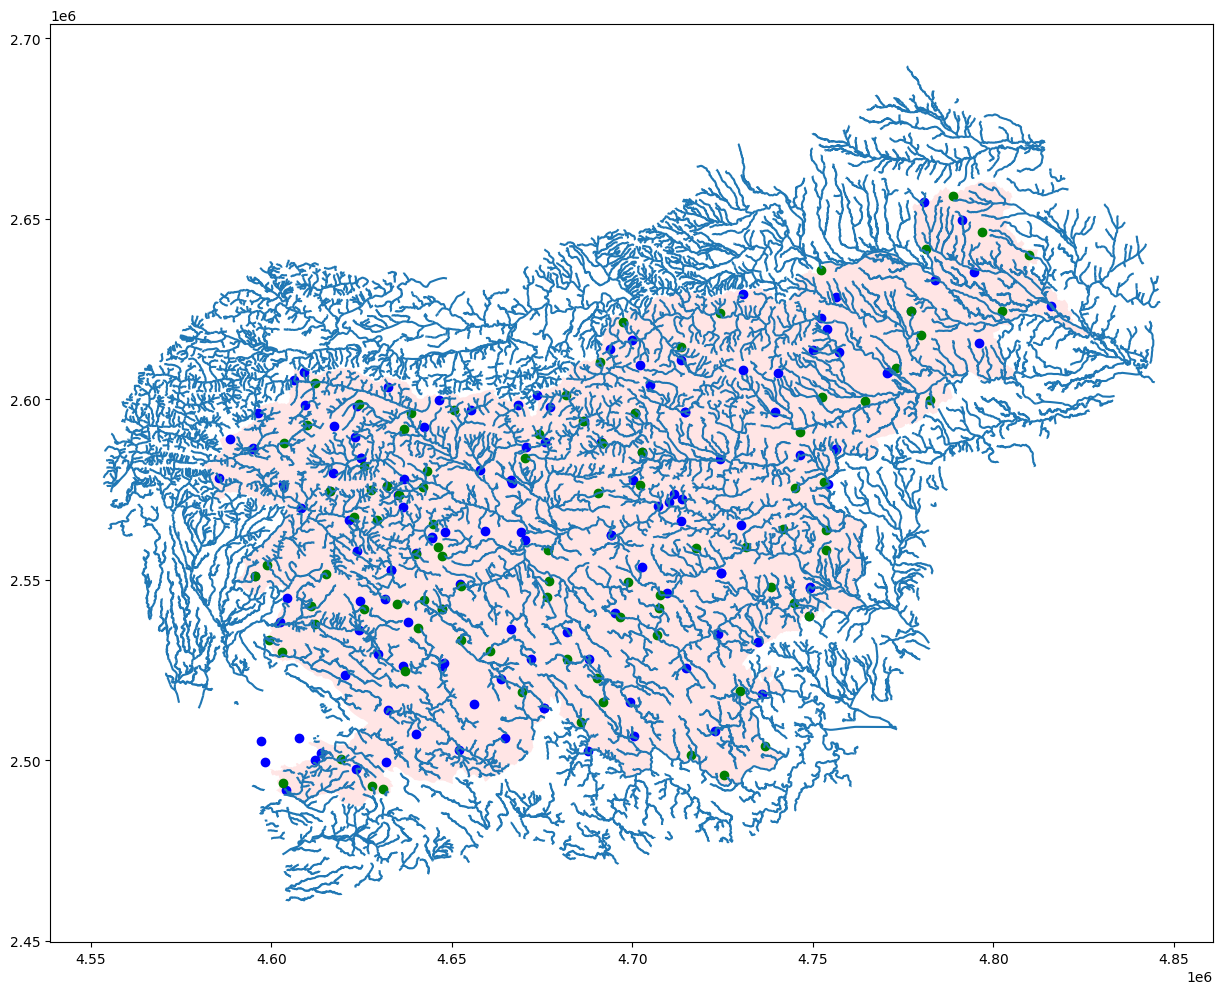

In [148]:
fig, ax = plt.subplots(figsize=(15, 15))

slovenia.plot(ax=ax, alpha=0.1, color='red')    
rivers_m.plot(ax=ax, alpha=1)

# plot on same ax closest weather stations

weather_stations_close = weather_stations_x.loc[rivers_m['closest_weather_ids'].explode().unique()]
prec_stations_close = prec_stations_m.loc[rivers_m['closest_prec_ids'].explode().unique()]

weather_stations_close.plot(ax=ax, color='blue', alpha=1)
prec_stations_close.plot(ax=ax, color='green', alpha=1)
